In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
 )

import csv
import os
from datetime import datetime

# import tensorflow as tf
# import tensorflow_datasets as tfds

import tensorflow as tf
mnist = tf.keras.datasets.mnist

algorithm_globals.random_seed = 12345
estimator = Estimator()

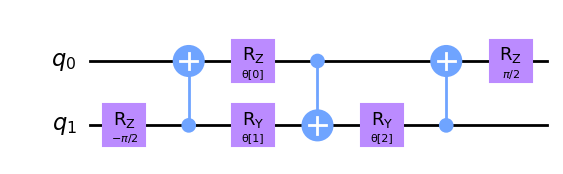

In [2]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

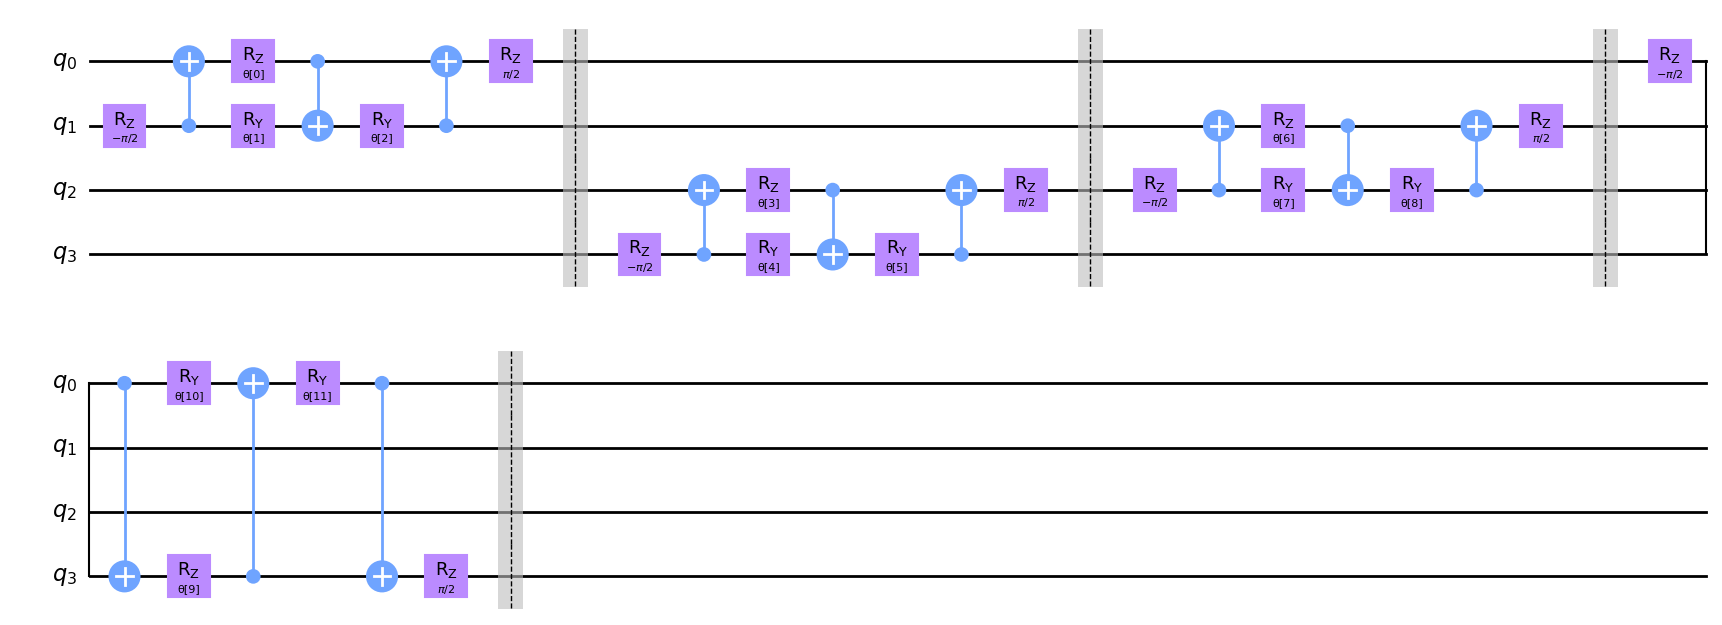

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

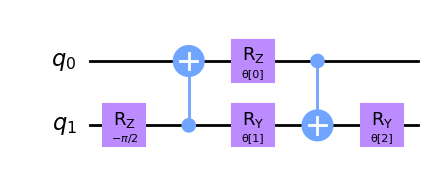

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

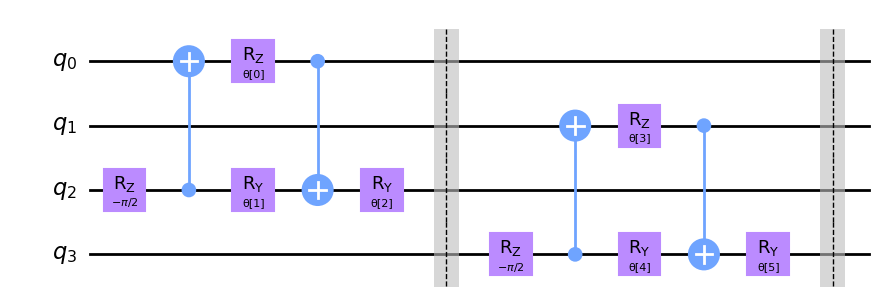

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

# Binario: <5 vs >=5
train_labels = np.where(train_labels < 5, -1, 1)
test_labels = np.where(test_labels < 5, -1, 1)

In [7]:
# Barrido de qubits (recomendado: potencias de 2 para esta QCNN)
min_qubits = 2
max_qubits = 8
n_qubits = max_qubits  # para que el resto del notebook (si lo usas) tenga un valor por defecto

# Tamaños de dataset (submuestras)
n_train = 700
n_test = 300

rng = np.random.default_rng(12345)

X_train = train_images.reshape(len(train_images), -1)  # (60000, 784)
X_test = test_images.reshape(len(test_images), -1)      # (10000, 784)

idx_train = rng.choice(len(X_train), size=n_train, replace=False)
idx_test = rng.choice(len(X_test), size=n_test, replace=False)

X_train_small = X_train[idx_train]
y_train_small = train_labels[idx_train]
train_images_small = train_images[idx_train]

X_test_small = X_test[idx_test]
y_test_small = test_labels[idx_test]
test_images_small = test_images[idx_test]

print("Subsets:", X_train_small.shape, X_test_small.shape)
print("Qubit sweep:", min_qubits, "->", max_qubits)

Subsets: (700, 784) (300, 784)
Qubit sweep: 2 -> 8


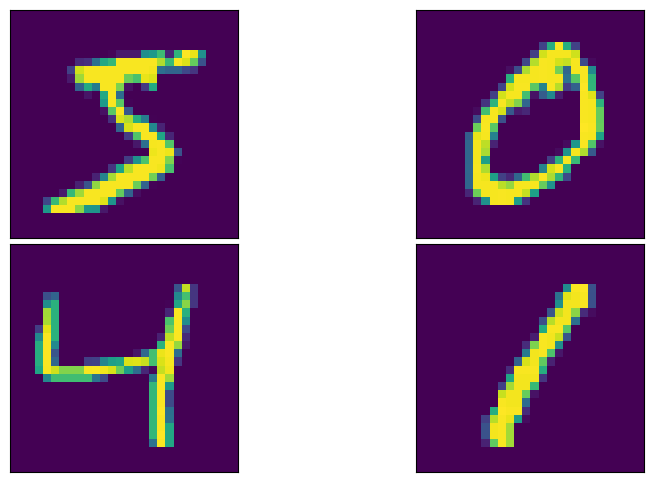

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(28, 28),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [9]:
def build_qcnn(start_qubits: int, stages: int) -> QuantumCircuit:

    ansatz = QuantumCircuit(start_qubits, name="Ansatz")
    # bloque activo: lista de índices globales que actualmente forman la entrada
    active = list(range(start_qubits))

    for s in range(stages):
        # aplicar capa convolucional sobre el bloque activo
        ansatz.compose(conv_layer(len(active), f"c{s+1}"), active, inplace=True)

        # si no se puede dividir más, salir
        if len(active) < 2:
            break

        # dividir el bloque activo (global) en dos mitades
        half = len(active) // 2
        superior_global = active[half:]

        # IMPORTANTE: pool_layer se define en coordenadas locales 0..len(active)-1
        inferior_local = list(range(half))
        superior_local = list(range(half, len(active)))

        # aplicar pooling sobre el bloque activo (mapeando local->global con `active`)
        ansatz.compose(
            pool_layer(inferior_local, superior_local, f"p{s+1}"),
            active,
            inplace=True,
        )

        # actualizar bloque activo a la mitad superior (global) para la siguiente etapa
        active = superior_global

    return ansatz

In [ ]:
# x = np.asarray(X_train_q)
# y = np.asarray(y_train_small)

# objective_func_vals = []
# plt.rcParams["figure.figsize"] = (12, 6)
# classifier.fit(x, y)

# # score classifier
# print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [11]:
# === Sweep de n_qubits y guardado a CSV (binario <5 vs >=5) ===
import time

def qubit_sweep_values(min_q: int, max_q: int):
    """Genera 2,4,8,... hasta max_q (incluido si es potencia de 2)."""
    q = int(min_q)
    if q < 2:
        q = 2
    while q <= int(max_q):
        yield q
        q *= 2

csv_path = "metrics_qcnn_mnist_sweep.csv"
fieldnames = [
    "timestamp",
    "n_qubits",
    "n_train",
    "n_test",
    "maxiter",
    "train_seconds",
    "accuracy",
    "balanced_accuracy",
    "kappa",
    "precision",
    "recall",
    "f1",
    "tn",
    "fp",
    "fn",
    "tp",
    "explained_variance_sum",
]

maxiter = 40  # iteraciones COBYLA por cada n_qubits
write_header = not os.path.exists(csv_path)

with open(csv_path, "a", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if write_header:
        writer.writeheader()

    for n_qubits_run in qubit_sweep_values(min_qubits, max_qubits):
        print("\n===== n_qubits =", n_qubits_run, "=====")

        # Reducir dimensionalidad (784 -> n_qubits_run) con SVD y mapear a ángulos
        svd = TruncatedSVD(n_components=n_qubits_run, random_state=12345)
        X_train_red = svd.fit_transform(X_train_small)
        X_test_red = svd.transform(X_test_small)

        scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
        X_train_q = scaler.fit_transform(X_train_red)
        X_test_q = scaler.transform(X_test_red)

        # Construir QNN para este n_qubits_run
        feature_map = ZFeatureMap(n_qubits_run)
        stages = int(np.log2(n_qubits_run))
        ansatz = build_qcnn(start_qubits=n_qubits_run, stages=stages)

        circuit = QuantumCircuit(n_qubits_run)
        circuit.compose(feature_map, range(n_qubits_run), inplace=True)
        circuit.compose(ansatz, range(n_qubits_run), inplace=True)

        observable = SparsePauliOp.from_list([("Z" + "I" * (n_qubits_run - 1), 1)])
        qnn = EstimatorQNN(
            circuit=circuit.decompose(),
            observables=observable,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            estimator=estimator,
        )

        classifier = NeuralNetworkClassifier(
            qnn,
            optimizer=COBYLA(maxiter=maxiter),
            # callback=callback_graph,  # desactivado en sweep para evitar 1 plot por iteración
        )

        # Entrenar
        t0 = time.perf_counter()
        classifier.fit(np.asarray(X_train_q), np.asarray(y_train_small))
        train_seconds = time.perf_counter() - t0

        # Evaluar
        y_predict = classifier.predict(np.asarray(X_test_q))
        y_test = np.asarray(y_test_small)

        acc = accuracy_score(y_test, y_predict)
        bal_acc = balanced_accuracy_score(y_test, y_predict)
        kappa = cohen_kappa_score(y_test, y_predict)
        precision = precision_score(y_test, y_predict, pos_label=1, zero_division=0)
        recall = recall_score(y_test, y_predict, pos_label=1, zero_division=0)
        f1 = f1_score(y_test, y_predict, pos_label=1, zero_division=0)

        cm = confusion_matrix(y_test, y_predict, labels=[-1, 1])
        tn, fp, fn, tp = cm.ravel()

        print(f"Accuracy: {acc:.4f} | Balanced: {bal_acc:.4f} | Kappa: {kappa:.4f}")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print(f"Train seconds: {train_seconds:.2f}")

        row = {
            "timestamp": datetime.now().isoformat(timespec="seconds"),
            "n_qubits": int(n_qubits_run),
            "n_train": int(n_train),
            "n_test": int(n_test),
            "maxiter": int(maxiter),
            "train_seconds": float(train_seconds),
            "accuracy": float(acc),
            "balanced_accuracy": float(bal_acc),
            "kappa": float(kappa),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "tn": int(tn),
            "fp": int(fp),
            "fn": int(fn),
            "tp": int(tp),
            "explained_variance_sum": float(svd.explained_variance_ratio_.sum()),
        }
        writer.writerow(row)

print(f"\nSweep completado. CSV: {os.path.abspath(csv_path)}")

C:\Users\BlackKnight\AppData\Local\Temp\ipykernel_29204\3217726331.py:55: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(n_qubits_run)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.



===== n_qubits = 2 =====


C:\Users\BlackKnight\AppData\Local\Temp\ipykernel_29204\3217726331.py:55: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(n_qubits_run)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Accuracy: 0.5033 | Balanced: 0.5043 | Kappa: 0.0085
Precision: 0.4841 | Recall: 0.5278 | F1: 0.5050
Train seconds: 30.41

===== n_qubits = 4 =====


C:\Users\BlackKnight\AppData\Local\Temp\ipykernel_29204\3217726331.py:55: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(n_qubits_run)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Accuracy: 0.5300 | Balanced: 0.5288 | Kappa: 0.0577
Precision: 0.5106 | Recall: 0.5000 | F1: 0.5053
Train seconds: 77.04

===== n_qubits = 8 =====
Accuracy: 0.5667 | Balanced: 0.5662 | Kappa: 0.1324
Precision: 0.5479 | Recall: 0.5556 | F1: 0.5517
Train seconds: 182.89

Sweep completado. CSV: c:\Users\BlackKnight\Desktop\uni\TFG\metrics_qcnn_mnist_sweep.csv
